Данный проект по определению самого выгодной платформы. Для прогноза использую метод к соседий классификации

In [4]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML/Проекты/k-neubors/Supplement_Sales_Weekly_Expanded.csv", delimiter=',')

In [5]:
import plotly.express as px
px.box(data['Units Sold'])

Описание данных:
*   Date 	- дата категориальный признак.
*   Product Name 	- название добавки категориальный признак
*   Category 	- категория добавки категориальный признак
*   Units Sold 	- количество проданного товара числовой признак
*   Price - цена товара числовой признак
*   Revenue 	- доход числовой признак
*   Discount 	- скидка на товар числовой признак
*   Units Returned 	- возвраты товаров числовой признак
*   Location - страна продажь категориальный признак
*   Platform  - платформа категориальный признак

In [ ]:
data.head()

,Date,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
0,2020-01-06,Whey Protein,Protein,143,31.98,4573.14,0.03,2,Canada,Walmart
1,2020-01-06,Vitamin C,Vitamin,139,42.51,5908.89,0.04,0,UK,Amazon
2,2020-01-06,Fish Oil,Omega,161,12.91,2078.51,0.25,0,Canada,Amazon
3,2020-01-06,Multivitamin,Vitamin,140,16.07,2249.80,0.08,0,Canada,Walmart
4,2020-01-06,Pre-Workout,Performance,157,35.47,5568.79,0.25,3,Canada,iHerb


В данном датасете отсуствуют пропуски.


In [ ]:
# Основная информация о данных
# Размер датасета
print(f"Размер датасета: {data.shape}")

# Типы данных
print("\nТипы данных:")
print(data.dtypes)

# Проверка на пропуски
print("\nПропущенные значения:")
print(data.isnull().sum())

NameError: name 'data' is not defined

1.   Удаляем столбец 'Date'так,как он не несет полезной информации для прогноза.Перевод из строки в числовой формат усложнит модель и может внести шум без явной пользы.
2.   Удаляем столбец 'Product Name', поскольку его часть дублируется в столбце 'Category', который при этом сокращает список наименований и упрощает их преобразование в числовой формат.



In [ ]:
supplements = data.drop(['Date','Product Name'], axis =1)


**Уникальные платформы:**
*   'Walmart'
*   'Amazon'
*   'iHerb'

**Уникальные локации:**
*   'Canada'
*   'UK'
*   'USA'


**Уникальные категории:**
*   'Protein'
*  'Vitamin'
*  'Omega'
*   'Performance'
*   'Amino Acid'
*   'Mineral'
*   'Herbal'
*   'Sleep Aid'
*   'Fat Burner'
*   'Hydration'



In [ ]:
# Получаем и выводим уникальные значения для каждого столбца
# Уникальные платформы
unique_platforms = supplements['Platform'].unique()
print("Уникальные платформы:", unique_platforms)

# Уникальные локации
unique_locations = supplements['Location'].unique()
print("\nУникальные локации:", unique_locations)

# Уникальные категории товаров
unique_categories = supplements['Category'].unique()
print("\nУникальные категории:", unique_categories)

Уникальные платформы: ['Walmart' 'Amazon' 'iHerb']

Уникальные локации: ['Canada' 'UK' 'USA']

Уникальные категории: ['Protein' 'Vitamin' 'Omega' 'Performance' 'Amino Acid' 'Mineral' 'Herbal'
 'Sleep Aid' 'Fat Burner' 'Hydration']


In [ ]:
supplements.head()

,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
0,Protein,143,31.98,4573.14,0.03,2,Canada,Walmart
1,Vitamin,139,42.51,5908.89,0.04,0,UK,Amazon
2,Omega,161,12.91,2078.51,0.25,0,Canada,Amazon
3,Vitamin,140,16.07,2249.80,0.08,0,Canada,Walmart
4,Performance,157,35.47,5568.79,0.25,3,Canada,iHerb


**Преобразование категориальных признаков**
1.   Для целевой переменной Platform я буду использовать Label Encoding (Простое числовое кодирование)
*   Каждому уникальному значению присваивается число (0, 1, 2, ...).
*   kNN требует, чтобы целевая переменная была числовой.
*   Данное решение является простым и понятным, при этом не увеличивает число столбцов.
2.   Для номенальных признаков Location я буду использовать One-Hot Encoding(Горячее кодирование)
*   Каждая категория превращается в отдельный столбец с 0 и 1.
*   Нет ложного порядка (все категории равнозначны).
*   kNN будет корректно считать расстояния.
3.   Для номенальных признаков Category я буду использовать Frequency Encoding(частотное кодирование)
*   Каждой категории присваивается число, равное частоте её встречаемости в данных.
*   Много категорий, One-Hot создаст слишком много столбцов.





In [ ]:
from sklearn.preprocessing import LabelEncoder

# 1. Platform Label Encoding (Простое числовое кодирование)
le = LabelEncoder() #Это инструмент из библиотеки sklearn, который преобразует текстовые метки в числа.
supplements['Platform'] = le.fit_transform(supplements['Platform']) #fit — изучает все уникальные значения в столбце, transform — заменяет их на числа.

# 2. Location One-Hot Encoding (Горячее кодирование)
supplements = pd.get_dummies(supplements, columns=['Location'], dtype=int) #pd.get_dummies() которая преобразует категории в бинарные столбцы (0 или 1).

# 3. Category Frequency Encoding (частотное кодирование)
freq_map = supplements['Category'].value_counts(normalize=True).to_dict() #value_counts(normalize=True) Считает частоту каждой категории в столбце,to_dict() Превращает результат в словарь вида:{'Protein': 0.25, 'Vitamin': 0.35, 'Omega': 0.15, ...}
supplements['Category_encoded'] = supplements['Category'].map(freq_map) #Заменяет каждое значение в Category на соответствующую частоту из словаря.
supplements = supplements.drop('Category', axis=1)

In [ ]:
supplements.head()

,Units Sold,Price,Revenue,Discount,Units Returned,Platform,Location_Canada,Location_UK,Location_USA,Category_encoded
0,143,31.98,4573.14,0.03,2,1,1,0,0,0.1250
1,139,42.51,5908.89,0.04,0,0,0,1,0,0.1875
2,161,12.91,2078.51,0.25,0,0,1,0,0,0.0625
3,140,16.07,2249.80,0.08,0,1,1,0,0,0.1875
4,157,35.47,5568.79,0.25,3,2,1,0,0,0.1250


**Распределение целевой переменной близко к равномерному, что снижает риск смещения модели в сторону более представленных классов**

Распределение классов:
Platform
iHerb      1499
Amazon     1473
Walmart    1412
Name: count, dtype: int64


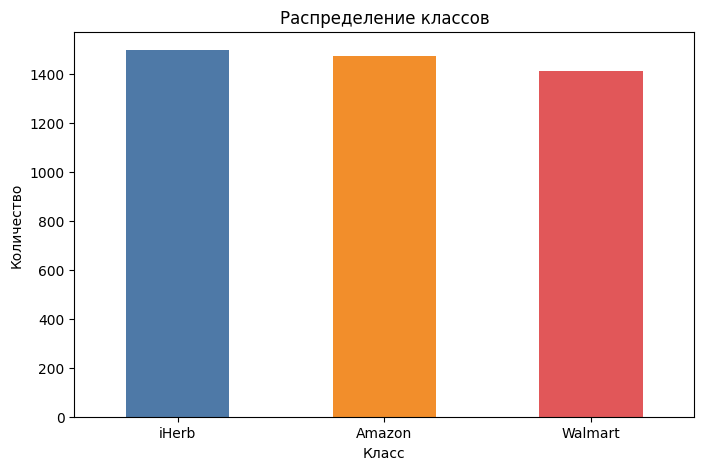

In [ ]:
# Распределение классов
class_dist = data['Platform'].value_counts()
print("Распределение классов:")
print(class_dist)

# Визуализация
colors = ['#4E79A7', '#F28E2B', '#E15759']
plt.figure(figsize=(8,5))
class_dist.plot(kind='bar',color=colors)
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.show()

**Units Sold (Количество проданных единиц)**

*   Большинство товаров продаётся в диапазоне ~100–400 единиц.
*   Есть редкие товары с очень высокими продажами (правая часть графика) — это возможные выбросы.



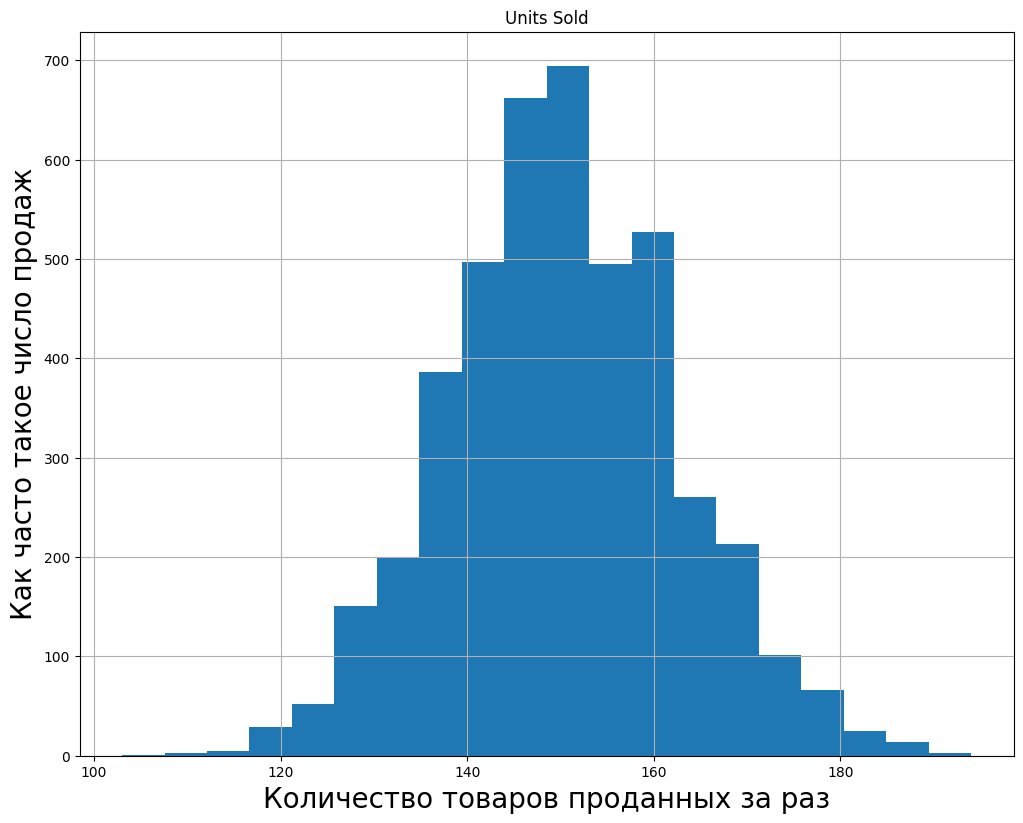

In [ ]:
supplements[['Units Sold']].hist(figsize=(10,8), bins=20)
plt.tight_layout()
plt.xlabel('Количество товаров проданных за раз',fontsize=20)
plt.ylabel('Как часто такое число продаж',fontsize=20)
plt.show()

** Price (Цена за единицу)**


*   В диапазоне выше 50 цен наблюдается снижение частот — что указывает на редкие более дорогие товары.
*   Есть небольшая "горка" или пик около 20-30, что говорит о том, что большинство товаров имеют цены в этом диапазоне.


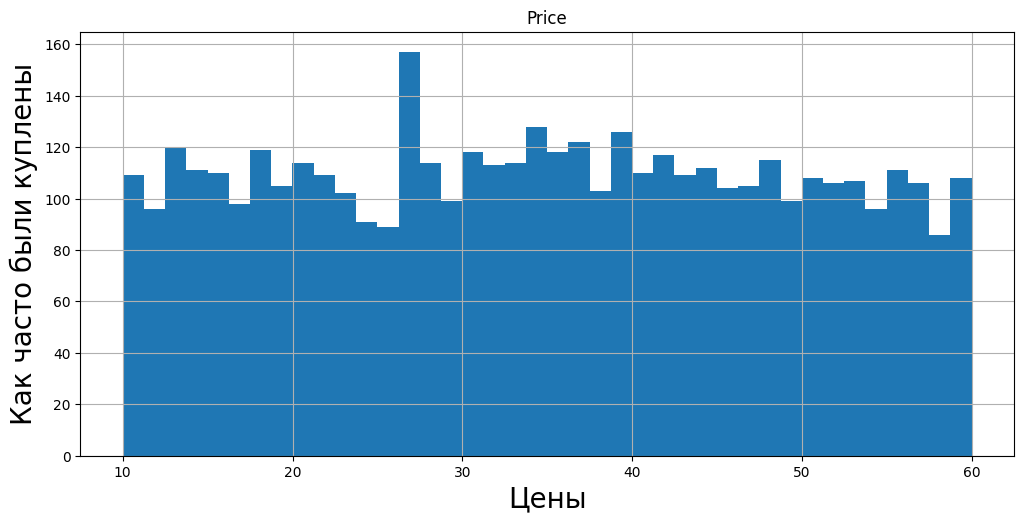

In [ ]:
supplements[['Price']].hist(figsize=(10,5),bins=40)
plt.tight_layout()
plt.xlabel('Цены',fontsize=20)
plt.ylabel('Как часто были куплены',fontsize=20)
plt.show()

**Revenue (Выручка)**

*  Распределение похоже на симметричную или близкую к симметричной форму, с пиком в районе примерно 4000–5000, где наблюдается наибольшее количество товаров.
*   Есть некоторый спад с обеих сторон от пика, означающий, что большинство товаров имеют доход в среднем диапазоне.
*   Самое частое значение — около 4000–5000, так как на этом диапазоне наблюдается максимум частот.
*  Значения доходов варьируются примерно от 1000 до 11000
*   Есть явные "хвосты" в обе стороны, что говорит о наличии товаров с очень низкими и очень высокими доходами, но их количество значительно меньше.



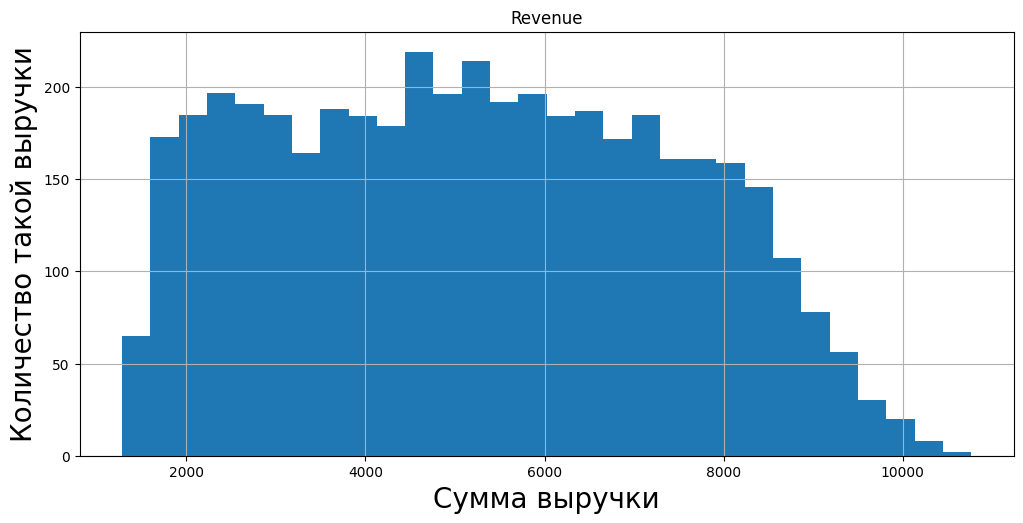

In [ ]:
supplements[['Revenue']].hist(figsize=(10,5),bins=30)
plt.tight_layout()
plt.xlabel('Сумма выручки',fontsize=20)
plt.ylabel('Количество такой выручки',fontsize=20)
plt.show()


**Discount (Скидка)**
*   Наибольшая частота наблюдается в интервале около 0.05–0.10.




In [ ]:
supplements[['Discount']].hist(figsize=(10,5),bins=20)
plt.tight_layout()
plt.xlabel('Скидка',fontsize=20)
plt.ylabel('Количество раз скидки',fontsize=20)
plt.show()

NameError: name 'supplements' is not defined

**Units Returned (Возвраты)**


*   Большинство товаров имеют 0–2 возврата
*   Есть редкие случаи с 5–8 возвратами — возможно, бракованные партии.
*   Много случаев с нулевым возвратом — означает, что часть товаров не вызывает необходимость возврата вовсе.




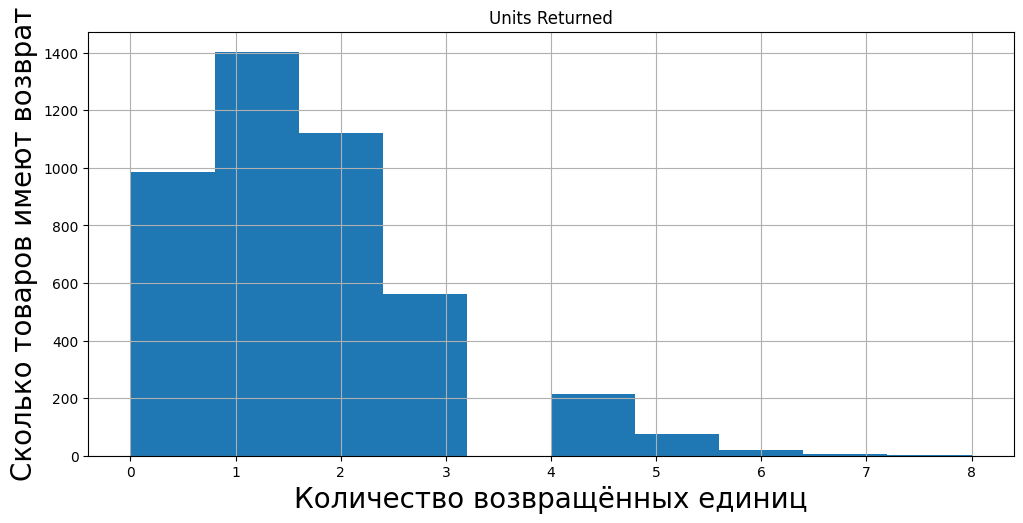

In [ ]:
supplements[['Units Returned']].hist(figsize=(10,5),bins=10)
plt.tight_layout()
plt.xlabel('Количество возвращённых единиц',fontsize=20)
plt.ylabel('Сколько товаров имеют возврат',fontsize=20)
plt.show()

In [ ]:
# График для Units Sold
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(supplements['Units Sold'])
plt.title('Units Sold')

# График для Price
plt.subplot(1, 2, 2)
plt.boxplot(supplements['Price'])
plt.title('Price')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
max_val = supplements['Units Sold'].max()

min_val = supplements['Units Sold'].min()

median_val = supplements['Units Sold'].median()

print(f"Максимальное значение Units Sold: {max_val}")
print(f"Минимальное значение Units Sold: {min_val}")
print(f"Медиана Units Sold: {median_val}")

Максимальное значение Units Sold: 194
Минимальное значение Units Sold: 103
Медиана Units Sold: 150.0
